# Clustering for emotions classification in text

## Contexte

Nous souhaitons utiliser le clustering (dont Kmeans) pour analyser les données texte annotées (émotions) en notre possession, identifier les documents anormaux et obtenir des piste pour améliorer les résultats de classification.

En commençant par le premier jeux de donnée (Kaggle le plus petit)

1. Est-que les clusters obtenue avec kmeans reflete les groupements de texte par émotions ?
2. Comparer les résultats de plusieurs modéles dans un tableaux avec le temps, l'inertie, la NMI, la AMI, l'ARI Index et la silhouette.
3. Quelle est le nombre de cluster optimal au regard de la métrique "silhouette" ? de l'inertie ?  est ce que l'inertie est corrélé à la mesure de silhouette ?
4. Reproduire ces expériences avec le jeux de donnée 2.
5. Peut-on identifier des cluster de documents ou des émotion difficile à classifier ? (ie cluster non homogéne)


## Ressources

* https://le-datascientist.fr/apprentissage-supervise-vs-non-supervise
* https://realpython.com/k-means-clustering-python/#writing-your-first-k-means-clustering-code-in-python
* https://mrmint.fr/algorithme-k-means (fr)
* https://scikit-learn.org/stable/modules/clustering.html#clustering
* https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD

from kneed import KneeLocator

from time import time

import nltk
from nltk.corpus import stopwords

print(__doc__)

Automatically created module for IPython interactive environment


## Kaggle data set

In [2]:
# GLOBAL VARIBLES

stopwords = nltk.corpus.stopwords.words("english")

df = pd.read_csv('./data/Emotion_final.csv')
print(df.info())

corpus = df.Text
print(type(corpus), corpus.shape)

targets = df.Emotion
print(type(targets), targets.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB
None
<class 'pandas.core.series.Series'> (21459,)
<class 'pandas.core.series.Series'> (21459,)


In [3]:
cv = CountVectorizer(stop_words=stopwords)
X = cv.fit_transform(corpus)
print(type(X), X.shape)

le = LabelEncoder()
y = le.fit_transform(targets)
print(type(y), y.shape)

words = cv.get_feature_names()
print("vocabulary size : %d" % len(words))

<class 'scipy.sparse.csr.csr_matrix'> (21459, 19070)
<class 'numpy.ndarray'> (21459,)
vocabulary size : 19070


### K-means clustering

Text(0, 0.5, 'Inertia')

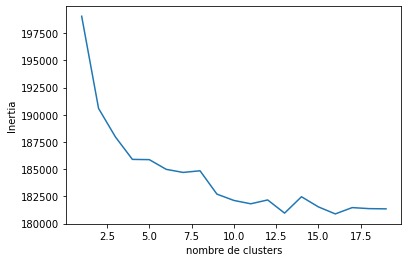

In [4]:
# Number of clusters selection with elbow method
inertia = []
K_range = range(1, 20)
for k in K_range:
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia_)

plt.plot(K_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('Inertia')

### 1. Est-que les clusters obtenus avec kmeans refletent les groupements de texte par émotions ?

In [5]:
n_clusters = KneeLocator(range(1, 20), inertia, curve="convex", direction="decreasing").elbow
print("Clusters number according to ELBOW method = ", n_clusters)

Clusters number according to ELBOW method =  4


In [6]:
data = X
labels = y
n_samples, n_emotions = data.shape[0], np.unique(labels).size

print(f"# Samples : {n_samples} ; # Labels (emotions) : {n_emotions}")

# Samples : 21459 ; # Labels (emotions) : 6


### Avec n_clusters <> n_emotions => on peut dire que NON !?

In [7]:
def bench_clustering(model, name, data, labels):
    
    t0 = time()
    estimator = make_pipeline(StandardScaler(with_mean=False), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    
    # Define the metrics which require only the true labels and estimator labels
    clustering_metrics = [
        metrics.normalized_mutual_info_score,
        metrics.adjusted_mutual_info_score,
        metrics.adjusted_rand_score,
        metrics.accuracy_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    
    # The silhouette score requires the full dataset
    results += [metrics.silhouette_score(data, estimator[-1].labels_, metric="euclidean")]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}\t\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}")
    print(formatter_result.format(*results))

### 2. comparer les résultats de plusieurs modéles dans un tableaux avec le temps, l'inertie, la NMI, la AMI, l'ARI Index et la silhouette.

In [8]:
print(100 * '_')
print('Init\t\tTime (s)\tInertia\t\tNMI\tAMI\tARI\tAccuracy\tSilhouette')

model = KMeans(init="k-means++", n_clusters=n_emotions, random_state=0)
bench_clustering(model=model, name="k-means++", data=data, labels=labels)

model = KMeans(init="random", n_clusters=n_emotions, random_state=0)
bench_clustering(model=model, name="k-means-random", data=data, labels=labels)

pca = TruncatedSVD(n_components=n_emotions).fit(data)
model = KMeans(init=pca.components_, n_clusters=n_emotions, n_init=1)
bench_clustering(model=model, name="K-means-PCA", data=data, labels=labels)
print(100 * '_')

____________________________________________________________________________________________________
Init		Time (s)	Inertia		NMI	AMI	ARI	Accuracy	Silhouette
k-means++	0.765		408284055	0.000	-0.000	-0.000	0.041		0.200
k-means-random	0.727		408847945	0.004	0.003	-0.001	0.124		0.007
K-means-PCA	0.317		408959262	0.004	0.003	0.010	0.145		0.049
____________________________________________________________________________________________________


### 3. Quelle est le nombre de cluster optimal au regard de la métrique "silhouette" ? de l'inertie ?  est ce que l'inertie est corrélé à la mesure de silhouette ?

Text(0, 0.5, 'Silhouette')

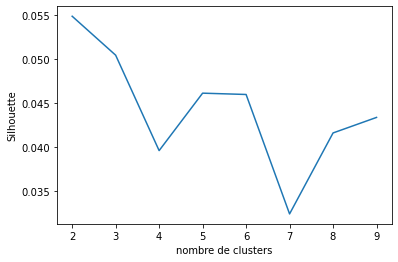

In [9]:
silhouette = []
K_range = range(2, 10)
for k in K_range:
    model = KMeans(init="k-means++", n_clusters=k).fit(X)
    silhouette.append(metrics.silhouette_score(X, model.labels_, metric="euclidean"))

plt.plot(K_range, silhouette)
plt.xlabel('nombre de clusters')
plt.ylabel('Silhouette')

 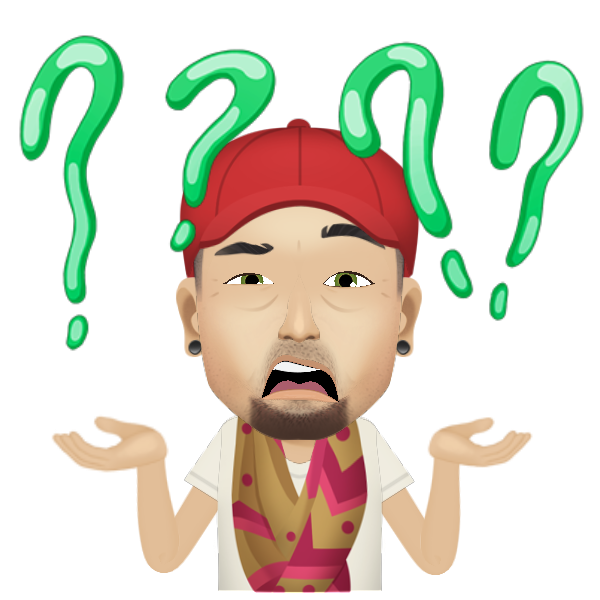

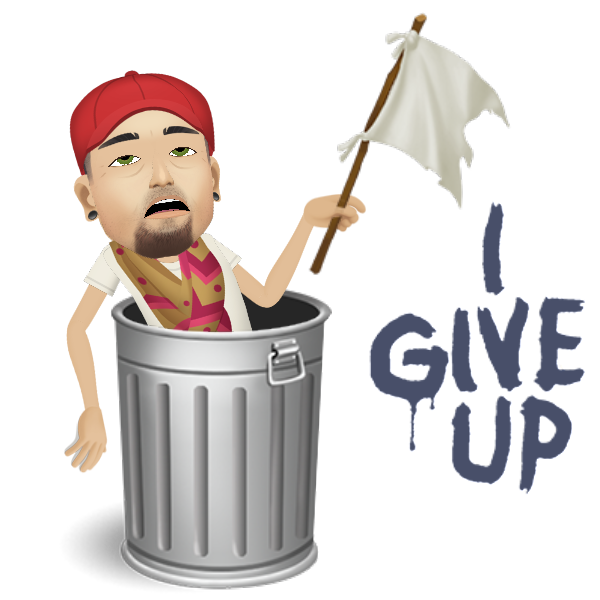